# Coronavirus Death Rate

Many trajectory plots, such as the superb ones The Financial Times is publishing at https://www.ft.com/coronavirus-latest use raw death and case counts, not per-capita rates.

This notebook explores plotting deaths-per-million, cases-per-million. More generally, MANY statistics can be plotted, including smoothed version of daily changes.

Datasets:

- cases and deaths by country from ECDC
- cases and deaths and tests by US state from covidtracking.com

## Random musings

Datasets wanted:

- location data
- testing by country and state
- population age structure? 
- lockdowns (and other interventions) by country and state

Plot ideas:

- plot rank change to see which ones are trending worse and which are trending better
- plot dpm change / dpm to plot the growth rate (slope) over time
- plt dpm change to plot the rate * base - base, which relates to hospital capacity.

In [1]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime  # love it!
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from coronavirus.data import load_all, load_nyc_age_comorbidity_death_data
from coronavirus.data import fill_before_first, add_per_day, add_nday_avg, before_threshold
from coronavirus.viz import plot_trajectories, days_since_trim, prioritize_entities

%reload_ext autoreload
%autoreload 2
%matplotlib inline

seasonal_flu_dpm: 114, bad_flu_dpm: 184


## Load Data

In [7]:
# takes a minute
states_df, countries_df, all_df = load_all(download=True)


In [3]:
df = states_df
df.groupby('entity').last().reset_index().tail().loc[:, ['entity', 'date', 'deaths_per_case']]

,entity,date,deaths_per_case
47,Virginia,2020-05-04,0.035091
48,Washington,2020-05-04,0.054923
49,West Virginia,2020-05-04,0.041459
50,Wisconsin,2020-05-04,0.041282
51,Wyoming,2020-05-04,0.011945


In [4]:
states_df.head()
countries_df.head()
df = countries_df
df[df['entity'] == 'United States']

,date,entity,cases,deaths,population,new_cases,new_deaths,cases_per_million,cases_per_day,cases_per_day_7day_avg,...,deaths_per_day,deaths_per_day_7day_avg,deaths_per_day_3day_avg,deaths_per_million_per_day,deaths_per_million_per_day_7day_avg,deaths_per_million_per_day_3day_avg,deaths_per_day_3day_avg_14day_ratio,deaths_per_case,deaths_per_case_per_day_7day_avg,deaths_per_case_per_day_3day_avg
14497,2019-12-31,United States,0,0,327167434.0,0,0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14498,2020-01-01,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
14499,2020-01-02,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
14500,2020-01-03,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
14501,2020-01-04,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14619,2020-05-01,United States,1069826,63006,327167434.0,29917,2040,3269.964822,29917.0,28664.857143,...,2040.0,1863.285714,2253.666667,6.235339,5.695205,6.888420,0.701713,0.058894,0.065002,0.083084
14620,2020-05-02,United States,1103781,65068,327167434.0,33955,2062,3373.749601,33955.0,30465.285714,...,2062.0,2007.285714,2237.666667,6.302583,6.135347,6.839515,0.610439,0.058950,0.065888,0.073609
14621,2020-05-03,United States,1133069,66385,327167434.0,29288,1317,3463.269514,29288.0,27716.571429,...,1317.0,1885.142857,1806.333333,4.025462,5.762013,5.521128,0.683785,0.058589,0.068015,0.058169
14622,2020-05-04,United States,1158041,67682,327167434.0,24972,1297,3539.597404,24972.0,27447.285714,...,1297.0,1829.428571,1558.666667,3.964331,5.591720,4.764125,0.632063,0.058445,0.066652,0.053007


In [5]:
print(f'What states have a population similar to New Zealand?')
print(list(states_df.loc[(states_df['population'] < 5e6) & (states_df['population'] > 3e6), :]
           .groupby('entity').first().sort_values(by='population').index))
print(f'What overlap is there between countries and states?')
print(set(states_df['entity']).intersection(countries_df['entity']))



What states have a population similar to New Zealand?
['Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon', 'Kentucky', 'Louisiana', 'Alabama']
What overlap is there between countries and states?
{'Georgia', 'Puerto Rico'}


## Trajectory Plots for deaths or deaths per million vs Date or Days Since

An excellent example of a similar plot of log(DPM) vs days since 0.1 DPM is https://ourworldindata.org/grapher/covid-deaths-days-since-per-million. It visually shows which countries are on similar trajectories, but makes it hard to compare the timeline of when interventions in countries are happening and what their outbreak looked like when those interventions were put in place.

Plotting log(DPM) vs date makes it harder to see the similarities of trajectories (though many of the trajectories look similar. Harder to plot those awesome sloped lines that say "doubles every 2 days", "doubles every 3 days", "doubles every 5 days", etc. Maybe an inset protractor-like graphic showing the doubling times.


### Hospital Beds

What is the medical capacity required to handle the peak of the infection. It depends on how full the beds are, at what rate new patients are coming in, and what rate old patients are leaving (death or recovery).

When plotted on a log(deaths per million) scale, what "slope" can a given amount of medical capacity (ICU beds, ventilators, healthcare workers, PPE, etc.) handle? Assume that the daily change in deaths per million is proportional (accounting for lag and growth changes) to incoming icu cases. For a steady state between incoming ICU cases and outgoing ICU cases (death and recovery), outgoing ICU cases (deaths and recoveries) must equal incoming ICU cases and therefore be proportional to delta deaths per million. And delta deaths per million relates deaths per million * slope. 

Why should we care? As deaths per million goes up, the slope must decrease to match hospital capacity. That means the government response must be stronger and more burdensome.
 
If delta_dpm exceeds this amount, than the number of incoming patients exceeds outgoing and must be absorbed by  available medical capacity. If delta_dpm is less than this amount, the number of incoming patients is less than the number of outgoing patients, and available hospital capacity increases.

low population entities
['Andorra', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Belize', 'Bermuda', 'Bhutan', 'British Virgin Islands', 'Brunei Darussalam', 'Cape Verde', 'Cases on an international conveyance Japan', 'Cayman Islands', 'Comoros', 'Curaçao', 'Djibouti', 'Dominica', 'Faroe Islands', 'Fiji', 'French Polynesia', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Guernsey', 'Guyana', 'Holy See', 'Iceland', 'Isle of Man', 'Jersey', 'Liechtenstein', 'Luxembourg', 'Maldives', 'Malta', 'Monaco', 'Montenegro', 'Montserrat', 'New Caledonia', 'Northern Mariana Islands', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino', 'Sao Tome and Principe', 'Seychelles', 'Sint Maarten', 'Suriname', 'Turks and Caicos islands', 'United States Virgin Islands']
20 ['Belgium' 'Spain' 'Italy' 'United Kingdom' 'France' 'Netherlands'
 'Sweden' 'Ireland' 'EU' 'United States' 'Switzerland' 'Canada' 'Portugal'
 'Denmark' 'Finland' 'Norway' 'South Korea' 'Japan

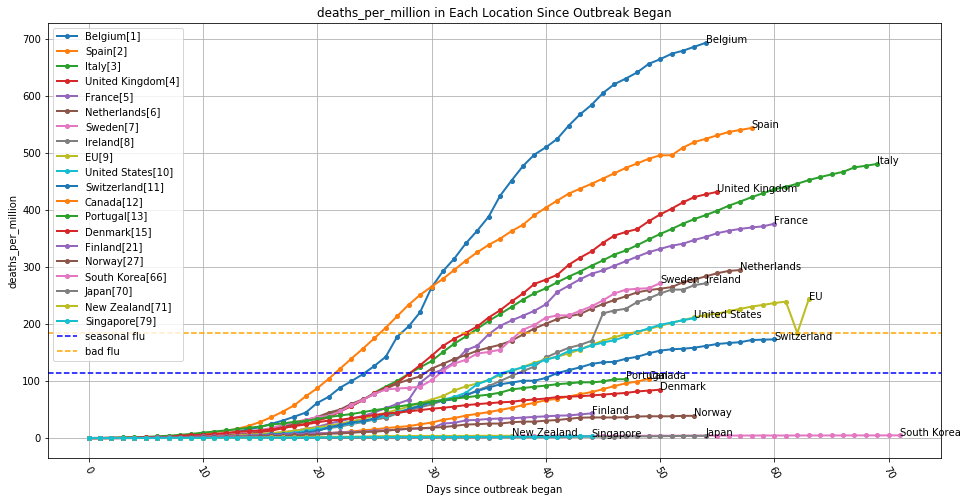

In [6]:
# lockdowns:
# Minnesota - stay-at-home 3/27 https://www.mprnews.org/story/2020/03/25/latest-on-covid19-in-minnesota
# New Zealand - lockdown 3/25 https://www.washingtonpost.com/world/asia_pacific/new-zealand-isnt-just-flattening-the-curve-its-squashing-it/2020/04/07/6cab3a4a-7822-11ea-a311-adb1344719a9_story.html

# df = states_df
df = countries_df
# df = all_df

us_states = list(states_df['entity'].unique())
includes = list(set([
#     'Vermont', 
#     'California',
#     'Oregon',
#     'Washington', 
#     'New York', 
#     'Michigan', 'Louisiana', 
#     'Massachusetts',
#     'Rhode Island',
    'United States',
    'Japan', 
    'Singapore', 
    'South Korea',
    'Italy', 
    'Spain', 
    'France',
#             'China',
    'New Zealand',
#     'New York',
    'EU',
#     countries from https://www.washingtonpost.com/opinions/2020/04/08/is-swedens-lax-approach-coronavirus-backfiring/
    'Sweden',
    'Denmark', 
    'Norway', 'Finland', 
#     'Malta', 'United Kingdom', 'Italy',
# States ~3-5M in population
# 'Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon',
#              'Kentucky', 'Louisiana', 'Alabama',
    
]
# + us_states
# + eu_countries
))
low_pop_entities = list(df.loc[df['population'] < 1e6, 'entity'].unique())
print(f'low population entities\n{low_pop_entities}')
excludes = list(set([
# Excludes low-population entities with high deaths-per-capita.
'World',
'Puerto Rico',
#     'Louisiana'
] 
    + low_pop_entities
))

index_col = 'days_since'
# index_col = 'date'
log_yaxis = False

values_col = 'deaths_per_million'; log_yaxis = False
# values_col = 'deaths_per_million_per_day_7day_avg'; log_yaxis = False
# values_col = 'deaths_per_million_per_day_3day_avg'; log_yaxis = False
# values_col = 'deaths'
# values_col = 'deaths_per_day'
# values_col = 'deaths_ratio_per_day_7day_avg'
# values_col = 'deaths_per_day_7day_avg'
# values_col = 'deaths_per_case'; log_yaxis = False
# values_col = 'deaths_per_case_per_day_7day_avg'; log_yaxis = False
# values_col = 'cases_per_million'; log_yaxis = False
# values_col = 'cases_per_million_per_day_7day_avg'; log_yaxis = False
# values_col = 'cases_per_million_per_day_3day_avg'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg'
# values_col = 'cases'
# values_col = 'cases_per_test'; log_yaxis = False
# values_col = 'cases_per_day_7day_avg_tests_per_day_7day_avg_ratio'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg_14day_ratio'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio'; log_yaxis = False
# values_col = 'cases_per_test_per_day_3day_avg_14day_ratio'; log_yaxis = False
# values_col = 'deaths_per_test'; log_yaxis = False
# values_col = 'deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio'; log_yaxis = False
# values_col = 'deaths_per_test_per_day_3day_avg_14day_ratio'; log_yaxis = False

# FT threshold condition https://www.ft.com/coronavirus-latest 2020-03-02
# days_since_col = 'deaths_per_day'; days_since_thresh = 3.0
# FT thesh: number of days since 30 daily cases first recorded
# days_since_col = 'cases_per_day'; days_since_thresh = 30
# OWID threshold condition https://ourworldindata.org/grapher/covid-deaths-days-since-per-million
# days_since_col = 'deaths_per_million'; days_since_thresh = 0.1
# Other thresholds
# days_since_col = 'cases_per_million'; days_since_thresh = 1
# days_since_col = 'deaths'; days_since_thresh = 1
# days_since_col = 'cases'; days_since_thresh = 1
# days_since_col = 'deaths_per_day'; days_since_thresh = 1.0
# Good for 14day deaths/test ratio and cases/test ratio b/c earlier the ratio is huge.
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-15')
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-01')

# df = (df.pipe(add_per_day, columns=['deaths_per_case'])
#       .pipe(add_nday_avg, columns=['deaths_per_case_per_day'], n=7)
#      )
# values_col = 'deaths_per_case_per_day_7day_avg'; log_yaxis = False

index_col = 'days_since'
values_col = 'deaths_per_million'; log_yaxis = False
days_since_col = 'deaths_per_million'; days_since_thresh = 0.1

# df['deaths_per_day_7day_avg_per_cases_per_day_7day_avg'] = df['deaths_per_day_7day_avg'] / df['cases_per_day_7day_avg']
# # values_col = 'deaths_per_case'; log_yaxis = False
# values_col = 'deaths_per_day_7day_avg_per_cases_per_day_7day_avg'; log_yaxis = False
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-01')

n_top = 20
# n_top = len(includes)
n_show = n_top
rank = False
# rank = True
ascending = False
# ascending = True  # for cases/test 14day ratio, lower is better
show_legend = True

df = days_since_trim(df, index_col, days_since_col, days_since_thresh, values_col)
piv = plot_trajectories(df,
                        index_col=index_col, values_col=values_col, 
                        rank=rank, n_top=n_top, n_show=n_show,
                        includes=includes, excludes=excludes,
                        log_yaxis=log_yaxis,
                        ascending=ascending,
                        show_legend=show_legend,
                       )


In [73]:
(df.loc[(df['entity'].isin(['California', 'New York'])) &
       (df['date'] < to_datetime('2020-03-24')) & (df['date'] > to_datetime('2020-03-10')),
       ['date', 'entity', 'tests', 'cases', 'deaths']]
 .sort_values(by=['date', 'entity'])).fillna(0.0)

seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184


,date,entity,tests,cases,deaths
280,2020-03-11,California,1073.0,157.0,0.0
1998,2020-03-11,New York,308.0,216.0,0.0
279,2020-03-12,California,1118.0,202.0,4.0
1997,2020-03-12,New York,308.0,216.0,0.0
278,2020-03-13,California,1118.0,202.0,4.0
1996,2020-03-13,New York,3200.0,421.0,0.0
277,2020-03-14,California,1168.0,252.0,5.0
1995,2020-03-14,New York,3303.0,524.0,0.0
276,2020-03-15,California,1209.0,293.0,5.0
1994,2020-03-15,New York,5272.0,729.0,3.0


In [38]:
df = states_df
df.loc[(df['entity'] == 'Oregon') & (df['date'] > to_datetime('2020-04-20')), ['date', 'entity', 'deaths_per_million']]

,date,entity,deaths_per_million
2092,2020-04-21,Oregon,18.493329
2091,2020-04-22,Oregon,18.493329
2090,2020-04-23,Oregon,19.678799
2089,2020-04-24,Oregon,20.390081
2088,2020-04-25,Oregon,20.627175
2087,2020-04-26,Oregon,21.575551
2086,2020-04-27,Oregon,21.812645
2085,2020-04-28,Oregon,21.812645
2084,2020-04-29,Oregon,23.946491
2083,2020-04-30,Oregon,24.420679


In [44]:
df.groupby('entity').last().loc[:, ['date', 'deaths_per_million', 'cases_per_test', 'deaths_per_case']].sort_values('deaths_per_million')

,date,deaths_per_million,cases_per_test,deaths_per_case
entity,,,,
Hawaii,2020-04-30,11.300457,0.020007,0.026101
Wyoming,2020-04-30,12.094844,0.057591,0.012868
Alaska,2020-04-30,12.302729,0.018568,0.025352
Utah,2020-04-30,14.348285,0.043060,0.009846
Montana,2020-04-30,14.970368,0.032557,0.035320
South Dakota,2020-04-30,19.216444,0.143822,0.006942
Arkansas,2020-04-30,20.213374,0.067281,0.018740
West Virginia,2020-04-30,22.877588,0.025100,0.036673
Oregon,2020-04-30,24.420679,0.044796,0.041036


## Rate Trends

Tests per capita represents the amount of the total population that has been tested. It represents the scaling of testing infrastructure and the implementation of sentinel testing, contact tracing and other testing based containment measures. It represents the surging of tests in states with severe outbreaks.

Cases per test represents the sickness of the population being tested, the extent of the infection across the population, and the proportion of different sicknesses such as influenza among the population being tested.

Deaths per case represents the quality of health care, issues with over- or underusing ventilators, the population of people getting infected (such as people living in long-term care facilities), and increased recording/testing of coronavirus deaths.

n_top: 4, n_show: 200, includes: [], excludes: []


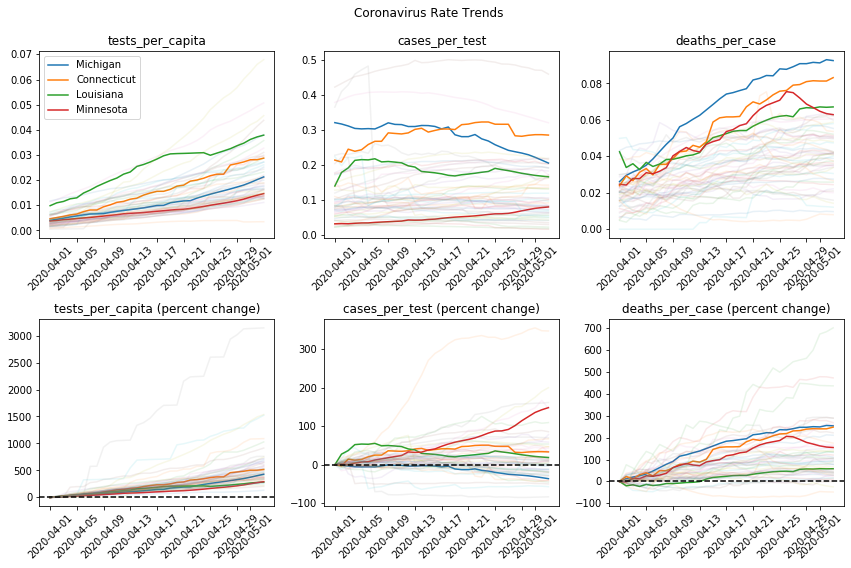

In [88]:
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-03-16');
days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-01');
df = states_df
df = df.assign(tests_per_capita=(1 * df['tests'] / df['population']))
df = df.loc[~before_threshold(df, days_since_col, days_since_thresh)]
df = df.loc[:, ['date', 'entity', 'population', 'tests_per_capita', 'cases_per_test', 'deaths_per_case']]

# states = ['Vermont', 'Michigan', 'New York', 'California', 'Georgia', 'Rhode Island', ]
# fig, axes = plt.subplots(len(states) // 3, 3, figsize=(14, 6), sharey=True)
# for i, state in enumerate(states):
#     ax = axes[i // 3, i % 3]
# #     df = df[df['entity'] == state]
#     ax.tick_params('x', labelrotation=45)
#     for col in ['tests_per_capita', 'cases_per_test', 'deaths_per_case']:
#         ax.plot(df.loc[df['entity'] == state, 'date'], 
#                 df.loc[df['entity'] == state, col], 
#                 label=col)
#         ax.set_title(state)

# plt.suptitle(f'Coronavirus Rate Trends')
# plt.legend()
# plt.tight_layout(rect=(0, 0, 1, 0.95))
# plt.show()

includes = [
#     'Vermont', 
#     'Massachusetts'
]
excludes = [
#     'Oregon', 
#     'Texas'
]
ascending = False
n_top = 4
n_show = 200
values_col = 'deaths_per_case'
index_col = 'date'
top_ents, show_ents, all_ents = prioritize_entities(
    df, index_col, values_col, ascending=ascending, 
    n_top=n_top, n_show=n_show, includes=includes, excludes=excludes)


fig, axes = plt.subplots(2, 3, figsize=(12,8))
background_alpha = 0.1
for i, col in enumerate(['tests_per_capita', 'cases_per_test', 'deaths_per_case']):
    ax = axes[0, i]
    for entity in all_ents:
        if entity in show_ents:
            alpha = 1 if entity in top_ents else background_alpha
            label = entity if entity in top_ents else None
            ax.plot(df.loc[df['entity'] == entity, 'date'], 
                    df.loc[df['entity'] == entity, col], 
                    alpha=alpha,
                    label=label)
            
    ax.set_title(col)
    ax.tick_params('x', labelrotation=45)
    if i == 0:
        ax.legend()
    
    ax = axes[1, i]
    for entity in all_ents:
        if entity in show_ents:
            alpha = 1 if entity in top_ents else background_alpha
            label = entity if entity in top_ents else None
            vals = df.loc[df['entity'] == entity, col]
            ax.plot(df.loc[df['entity'] == entity, 'date'], 
                    100 * (vals - vals.iloc[0]) / vals.iloc[0], 
                    alpha=alpha,
                    label=label)
    
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_title(f'{col} (percent change)')
    ax.tick_params('x', labelrotation=45)
#     ax.legend()

plt.suptitle(f'Coronavirus Rate Trends')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

